In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

2024-12-04 04:46:32.171873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733287592.186413   27880 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733287592.190827   27880 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 04:46:32.206155: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Load data
data = pd.read_csv('../csv/AAPL_from_2021.csv')  # Replace with actual file path
features = data[['close', 'volume', 'trade_count', 'vwap']].values  # Replace column names as per your dataset


In [3]:
# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler.fit_transform(features)

In [4]:
# Create datasets
train_size = int(len(features_scaled) * 0.8)
train_data, test_data = features_scaled[:train_size], features_scaled[train_size:]

In [5]:
# Create sequences
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(window_size, len(data)):
        X.append(data[i-window_size:i])
        y.append(data[i, 0])  # Predicting the 'Close' price
    return np.array(X), np.array(y)

window_size = 60
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

In [6]:
# Define LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Output layer

I0000 00:00:1733287593.624101   27880 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5473 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1060 6GB, pci bus id: 0000:01:00.0, compute capability: 6.1
/home/eli/alpaca-predict/.venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [7]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# Train model
model.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0014 - val_loss: 1.0958e-04
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 6.5150e-04 - val_loss: 1.0685e-04
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0023 - val_loss: 1.0443e-04
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.3611e-04 - val_loss: 1.0373e-04
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0012 - val_loss: 9.4386e-05
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0018 - val_loss: 1.9409e-04
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 9.7057e-04 - val_loss: 1.0205e-04
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 9.9818e-04 - val_loss: 9.9844e-05
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.4447e-04 - val_loss: 1.6443e-04
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 7.3961e-04 - val_loss: 1.1945e-04
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 7.9731e-04 - val_loss: 1.05

In [19]:
# Make predictions
predicted_prices = model.predict(X_test)
scaled_actual_prices = test_data[window_size:, 0].reshape(-1,1)
# actual_prices = scaler.inverse_transform(scaled_actual_prices)
predicted_prices = scaler.inverse_transform(np.concatenate([predicted_prices, np.zeros((predicted_prices.shape[0], features.shape[1]-1))], axis=1))[:,0]
test_data

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


array([[0.14765185, 0.22457649, 0.28090137, 0.14728275],
       [0.16713838, 0.31552619, 0.30839259, 0.16656885],
       [0.16696306, 0.16699451, 0.19010015, 0.16634774],
       ...,
       [0.32683782, 0.07438112, 0.09079076, 0.3252233 ],
       [0.33249843, 0.12973588, 0.15826944, 0.33263242],
       [0.34016281, 0.10362446, 0.14157244, 0.33792538]])

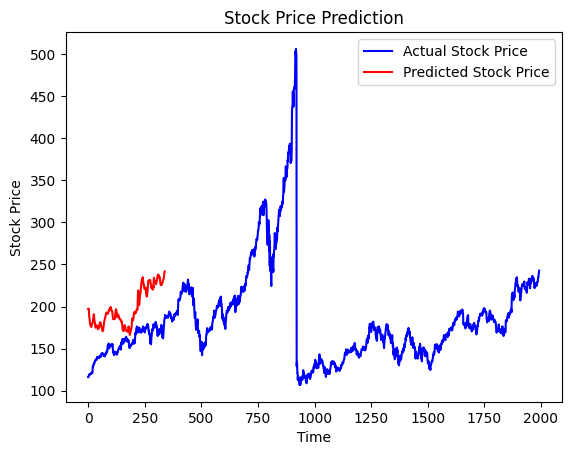

In [20]:
# Visualize results
plt.plot(data['close'], color='blue', label='Actual Stock Price')
plt.plot(predicted_prices, color='red', label='Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

In [11]:
# Save the model
model.save('../models/AAPL_lstm_model_with_additional_features.keras')